# The version of the 2-FAST notebook in which I (hopefully) don't insert stupid bugs
(And the interpolator should also be better)

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using TwoFAST
using Dierckx
using DelimitedFiles
using QuadOsc
using FunctionZeros
using TwoFAST

In [3]:
using Revise
using Will

### Interpolating N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
# THAT'S THE NEW INTERPOLATION SCHEME!!!
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [8]:
ℓ = 20.0
lidx = 22;

In [9]:
npzread("ell_vector.npy")[22]

20.0

### Evaluating Chebyshev coefficients

In [10]:
kmax = 200/13 
kmin = 2.5/7000
nχ = 100
χ = LinRange(26, 7000, nχ)
χ_list = LinRange(26, 7000, 10)
fix_chi = χ_list[7]
χ_fixed = χ_list[7]

#calculate coefficients of chebychev decomposition
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

In [11]:
coeff2 = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb, fix_chi, fix_chi), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff2[i,j,:] = c.coefs
        coeff2[j,i,:] = coeff2[i,j,:]
    end
end

In [55]:
k_cheb = chebpoints(n_cheb, kmin, kmax);
coeff3 = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(k_cheb, fix_chi, fix_chi), kmin, kmax); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff3[i,j,:] = c.coefs
        coeff3[j,i,:] = coeff3[i,j,:]
    end
end

### Loading my Ts

In [12]:
function load_Ts(folder)
    ell_vector = npzread("ell_vector.npy") 
    full_T = zeros(26, 100, 100, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

load_Ts (generic function with 1 method)

In [13]:
T_CC = load_Ts("T_tilde_CC")
T_CL = load_Ts("T_tilde_CL")
T_LL = load_Ts("T_tilde_LL")

#with chi evolution
w_CC = Will.w_ell_tullio(coeff, T_CC)
w_CL = Will.w_ell_tullio(coeff, T_CL)
w_LL = Will.w_ell_tullio(coeff, T_LL)

#without chi evolution
w_CC2 = Will.w_ell_tullio(coeff2, T_CC)
w_CL2 = Will.w_ell_tullio(coeff2, T_CL)
w_LL2 = Will.w_ell_tullio(coeff2, T_LL);

### Functions

In [14]:
function build_2FAST_chi_evolution(chi_array, label, ℓ)
    w_2F = zeros(length(chi_array))
    N = 30000
    kmin = 1e-5
    kmax = 1e7
    chi0 = 0.00001 
    ell = [Int(ℓ)] 
    RR = [1.0]

    if label == "LL"
        q = -2.1
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    # calculate M_ll at high ell, result gets saved to a file:
    f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
    write("out/F21EllCache", f21cache)

    # calculate all M_ll, result gets saved to a file:
    mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
    write("out/MlCache", mlcache)

    for i in 1:length(chi_array)
        println("Processing χ = $(chi_array[i])")
        # calculate wljj:
        w00 = Array{Float64}(undef, N, length(RR))
        function outfunc(wjj, ell, rr, RR)
            w00[:,:] = wjj[1]
        end
        rr = calcwljj(x->power_spectrum(x, chi_array[i], chi_array[i])/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
        interp= Spline1D(rr, w00[:,1])
        w00_interp = interp.(chi_array)*π/2
        
        w_2F[i] = w00_interp[i]
    end
    return w_2F
end;        

In [15]:
function calculate_2FAST(chi_array, label, ℓ, RR, power_spectrum)
    w_2F = zeros(length(chi_array))
    N = 30000
    chi0 = 0.001
    kmax = 1e7
    kmin = 1e-5
    ell = [Int(ℓ)] 
    RR = [RR]

    if label == "LL"
        q = -2.5
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end
    

    # calculate M_ll at high ell, result gets saved to a file:
    f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
    write("out/F21EllCache", f21cache)

    # calculate all M_ll, result gets saved to a file:
    mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
    write("out/MlCache", mlcache)

    w00 = Array{Float64}(undef, N, length(RR))
    function outfunc(wjj, ell, rr, RR)
        w00[:,:] = wjj[1]
    end
    rr = calcwljj(x->power_spectrum(x, 4675.333333333333, 4675.333333333333)/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
    interp= Spline1D(rr, w00[:,1])
    χ = LinRange(26, 7000, 100) 
    w00_interp = interp.(χ)*π/2
    
    return w00_interp
end;        

In [16]:
function double_bessel_zeros(ℓ, χ1, χ2, n)
    all_zeros = zeros(3*n)
    counter = 1 
    for i in 1:2*n
        a = besselj_zero(ℓ+0.5, i)/χ1
        b = besselj_zero(ℓ+0.5, i)/χ2
        if a < b
            all_zeros[counter] = a
            all_zeros[counter+1] = b
            counter += 2
        elseif a > b
            all_zeros[counter] = b
            all_zeros[counter+1] = a
            counter += 2
        elseif a == b
            all_zeros[counter] = a 
            counter += 1
        end
        if counter == 3*n
            break
        end     
    end
    return sort!(all_zeros)[n]
end

double_bessel_zeros (generic function with 1 method)

In [17]:
function move(nf, ng, zerosf, zerosg)
    zerof = zerosf(nf)
    zerog = zerosg(ng)
    if zerof < zerog
        nf += 1
        zerofg = zerof
    elseif zerof > zerog
        ng += 1
        zerofg = zerog
    elseif zerof == zerog
        nf += 1
        ng += 1
        zerofg = zerof
    else
        @warn "Something bad happened!"
    end
    return zerofg, nf, ng
end

function nzeros_two_function(n, zerosf::Function, zerosg::Function)
    nf = 1
    ng = 1
    zerofg = 0.
    for i in 1:n
        zerofg, nf, ng = move(nf, ng, zerosf, zerosg)
    end
    return zerofg
end

nzeros_two_function (generic function with 1 method)

In [18]:
function calc_qosc(χ_list, label, ℓ, RR, fix, power_spectrum)

    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end
    
    result_Ia = zeros(length(χ_list))
    #result_Ib = zeros(length(χ_list))
    

    if fix == false
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            first_bessel(n) = besselj_zero(ℓ+0.5, n)/(χ_list[i])
            second_bessel(n) = besselj_zero(ℓ+0.5, n)/(RR*χ_list[i])
            Ia, Ea = quadosc(x->power_spectrum(x, χ_list[i], RR*χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf,n->nzeros_two_function(n, first_bessel, second_bessel))
            #Ib, Eb = quadosc(x->power_spectrum(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    elseif fix == true
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            first_bessel(n) = besselj_zero(ℓ+0.5, n)/(χ_list[i])
            second_bessel(n) = besselj_zero(ℓ+0.5, n)/(RR*χ_list[i])
            Ia, Ea = quadosc(x->power_spectrum(x, 4675.333333333333,4675.333333333333)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf,  n->nzeros_two_function(n, first_bessel, second_bessel))
            #Ib, Eb = quadosc(x->power_spectrum(x, fix_chi,fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    end

    #=if fix == false
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            Ia, Ea = quadosc(x->power_spectrum(x, χ_list[i], RR*χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf,n->double_bessel_zeros(ℓ,χ_list[i], RR*χ_list[i], n))
            #Ib, Eb = quadosc(x->power_spectrum(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    elseif fix == true
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            first_bessel(n) = besselj_zero(ℓ+0.5, n)/(χ_list[i])
            second_bessel(n) = besselj_zero(ℓ+0.5, n)/(RR*χ_list[i])
            Ia, Ea = quadosc(x->power_spectrum(x, 4675.333333333333,4675.333333333333)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)*Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx), kmin, Inf, n->double_bessel_zeros(ℓ,χ_list[i], RR*χ_list[i], n))
            #Ib, Eb = quadosc(x->power_spectrum(x, fix_chi,fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    end=#

    return result_Ia#-result_Ib
end

calc_qosc (generic function with 1 method)

In [19]:
function calc_pad(χ_list, label, ℓ, RR, fix, power_spectrum)
    result_pquad = zeros(length(χ_list))
    
    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end

    if fix == false
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            f(x) = power_spectrum(x, χ_list[i], RR*χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)* Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx)
            pquad = Cubature.pquadrature(x->f(x), kmin, 2*kmax; reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
            result_pquad[i] = pquad 
        end
    elseif fix == true
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            f(x) = power_spectrum(x, χ_fixed, χ_fixed)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)* Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx)
            pquad = Cubature.pquadrature(x->f(x), kmin, 2*kmax; reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
            result_pquad[i] = pquad
        end
    end
    return result_pquad
end

calc_pad (generic function with 1 method)

In [20]:
function cheby_zero(k)
    if k == 1 
        return kmin
    end
    zero_cheby = []
    for i in 0:(k-2)
        z = cos.(π*(i+0.5)/(k-1))
        z = (kmax - kmin) / 2 * z .+ (kmin + kmax) / 2
        push!(zero_cheby, z)
    end
    reverse!(zero_cheby)
    return zero_cheby
end

cheby_zero (generic function with 1 method)

In [45]:
function T̃_qosc_style(pk, ℓ, χ_list, R, kmin, kmax, tracers)
    n_cheb = 128
    N = 2^14
    x = FastTransforms.clenshawcurtisnodes(Float64, N)
    x = (kmax - kmin) / 2 * x .+ (kmin + kmax) / 2
    k_cheb = chebpoints(n_cheb, minimum(minimum.(x)), maximum(maximum.(x)));
    c = chebinterp( pk(k_cheb,fix_chi,fix_chi), minimum(minimum.(x)), maximum(maximum.(x)))
    α_k = 10
    T = zeros(1, length(χ_list), length(χ_list), n_cheb+1 )

    if tracers == "CC"
        idx = 2
    elseif tracers == "CL"
        idx = 0 
    elseif tracers == "LL"
        idx = -2
    end

    for (aidx, a) in enumerate(χ_list)
        println("Processing χ = $a...")
        for i in 1:n_cheb+1
            copy_c = deepcopy(c) #copio l'interpolante
            copy_c.coefs .*= 0 #azzero i coeff del polinomio
            copy_c.coefs[i] = 1.
    
            #find zeros of the bessels functions. they're always the same.
            zero_list = [kmin]
            actual_zero = 0.
            n = 1
            while actual_zero < α_k*kmax#add zeroes first function
                actual_zero = besselj_zero(ℓ+0.5, n)/(a)
                n +=1 
                push!(zero_list, actual_zero)
            end
            
            actual_zero = 0.
            n = 1
            while actual_zero < α_k*kmax#add zeroes second function
                actual_zero = besselj_zero(ℓ+0.5, n)/(a*R)
                n +=1 
                push!(zero_list, actual_zero)
            end
    
            chebz = cheby_zero(i)
    
            for j in 1:length(chebz)
                push!(zero_list, chebz[j])
            end
    
            sort!(unique!(zero_list))
            
            push!(zero_list, kmax)
            zero_list = @. zero_list[zero_list<=kmax]
    
            results_to_sum = zeros(length(zero_list)-1)
            f(x) = copy_c(x)*Bessels.sphericalbesselj(ℓ, a*x)*Bessels.sphericalbesselj(ℓ, a*R*x) *(x^idx)
            Threads.@threads for myi in 1:length(zero_list)-1
            I, _ = quadgk(x-> f(x), zero_list[myi], zero_list[myi+1]; atol=zero(Float64), rtol=sqrt(eps(Float64)), order=9)
            results_to_sum[myi] = I
            end
    
            T[1, aidx, aidx, i] = sum(sort(results_to_sum))
        end
    end
    return T
end

T̃_qosc_style (generic function with 2 methods)

#### Test per cercare zeri dei chebpoly

In [78]:
n_cheb = 128
N = 2^14
x = FastTransforms.clenshawcurtisnodes(Float64, N)
x = (kmax - kmin) / 2 * x .+ (kmin + kmax) / 2
k_cheb = chebpoints(n_cheb, minimum(minimum.(x)), maximum(maximum.(x)));
c = chebinterp(power_spectrum(k_cheb,χ[1],χ[1]), minimum(minimum.(x)), maximum(maximum.(x)))

ChebPoly{1,Float64,Float64} order (128,) polynomial on [0.00035714285714227856,15.384615384615385]

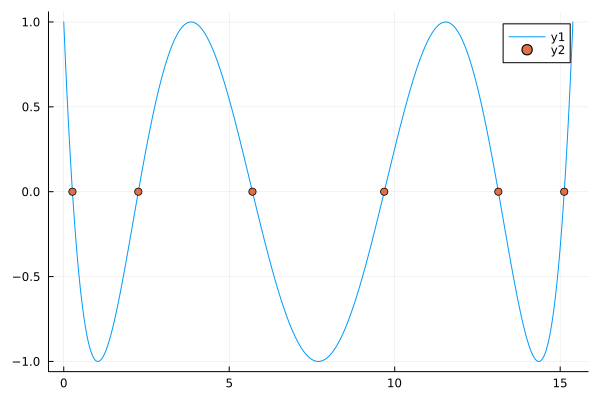

In [83]:
T = zeros(n_cheb+1,length(x))
Threads.@threads for i in 1:n_cheb+1
    copy_c = deepcopy(c) #copio l'interpolante
    copy_c.coefs .*= 0 #azzero i coeff del polinomio
    copy_c.coefs[i] = 1.
    T[i,:] = copy_c.(x)
end

n = 7

zero_cheby = []
for i in 0:(n-2)
    z = cos.(π*(i+0.5)/(n-1))
    z = (kmax - kmin) / 2 * z .+ (kmin + kmax) / 2
    push!(zero_cheby, z)
end

plot(x, T[n,:])
scatter!(zero_cheby, zeros(n-1))

# Let's start by matching quadosc and p-adaptive diagonals

### LL

In [21]:
result_Ia_LL = calc_qosc(χ_list, "LL", ℓ, 1.0, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 22.240878 seconds (15.89 M allocations: 1.348 GiB, 0.45% gc time, 2.33% compilation time)


In [22]:
result_pquad_LL = calc_pad(χ_list, "LL", ℓ, 1.0, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  0.834862 seconds (8.33 M allocations: 709.653 MiB, 3.63% gc time, 13.40% compilation time)


In [23]:
w_2F_LL = build_2FAST_chi_evolution(χ_list, "LL", ℓ);

  q=-2.1, R=1.0:	  0.007680 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006220 seconds (182 allocations: 638.156 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[1.0826418477584619e-32 + 0.0im, 0.0 + 0.0im]
ell 202, elapsed: 2.8133392333984375e-5
ell 201, elapsed: 0.26538705825805664
ell 200, elapsed: 0.0035529136657714844
ell 199, elapsed: 0.0010368824005126953
ell 198, elapsed: 0.0009989738464355469
  0.290636 seconds (454.89 k allocations: 30.476 MiB, 98.47% compilation time)
elapsed: 0.0013091564178466797
step:          0.083799 sec (107.509 k allocations: 7.59 MB, 0.0% gc time)
swapping:      4.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.02

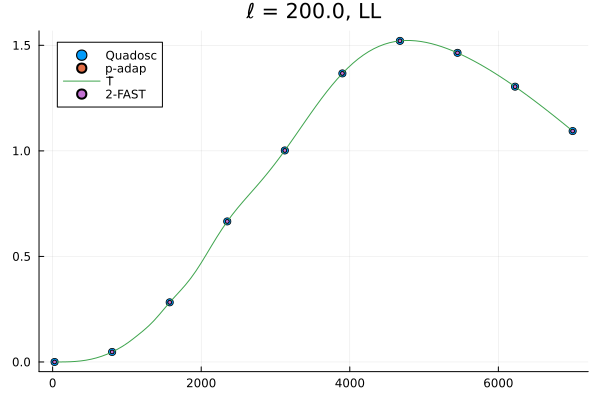

In [24]:
#scatter(χ_list, result_Ia_LL .- result_Ib_LL, label = "Quadosc")
scatter(χ_list, result_Ia_LL, label = "Quadosc", title="ℓ = $ℓ, LL")
scatter!(χ_list, result_pquad_LL, label = "p-adap", markersize = 2)
plot!(χ, diag(w_LL[lidx,:,:]), label="T̃")
scatter!(χ_list, w_2F_LL, label="2-FAST", markersize = 2)

### CL

In [25]:
result_Ia_CL = calc_qosc(χ_list, "CL", ℓ, 1.0, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 68.805973 seconds (44.89 M allocations: 7.636 GiB, 0.77% gc time, 0.00% compilation time)


In [26]:
result_pquad_CL = calc_pad(χ_list, "CL", ℓ, 1.0, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  1.167834 seconds (13.13 M allocations: 1.096 GiB, 4.22% gc time)


In [27]:
w_2F_CL = build_2FAST_chi_evolution(χ_list, "CL", ℓ);

  q=0.5, R=1.0:	  0.009315 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.002649 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[-1.3859567687499943 + 1.697307520606289e-16im, 0.0 + 0.0im]
ell 202, elapsed: 2.193450927734375e-5
ell 201, elapsed: 0.0001900196075439453
ell 200, elapsed: 0.0002281665802001953
ell 199, elapsed: 0.001055002212524414
ell 198, elapsed: 0.0010678768157958984
  0.004090 seconds (338 allocations: 17.742 KiB)
elapsed: 0.001310110092163086
step:          0.000369 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000114 sec (0 allocations: 0 

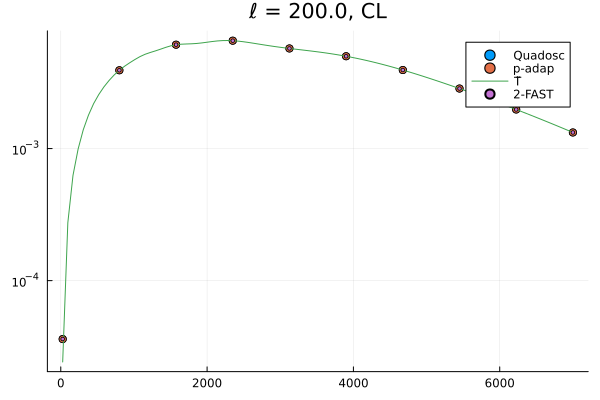

In [28]:
#scatter(χ_list, result_Ia_CL .- result_Ib_CL, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CL, label = "Quadosc", yscale=:log10, title = "ℓ = $ℓ, CL")
scatter!(χ_list, result_pquad_CL, label = "p-adap")
plot!(χ, diag(w_CL[lidx,:,:]), label="T̃")
scatter!(χ_list, w_2F_CL, label="2-FAST", markersize=2)

### CC

In [29]:
result_Ia_CC = calc_qosc(χ_list, "CC", ℓ, 1.0, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
638.419015 seconds (391.74 M allocations: 282.862 GiB, 2.42% gc time)


In [30]:
result_pquad_CC = calc_pad(χ_list, "CC", ℓ, 1.0, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  2.778277 seconds (30.82 M allocations: 2.572 GiB, 5.31% gc time)


In [31]:
w_2F_CC = build_2FAST_chi_evolution(χ_list, "CC", ℓ);

  q=1.1, R=1.0:	  0.008247 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005868 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[2.012514639968315e7 - 4.92923922414877e-9im, 0.0 + 0.0im]
ell 202, elapsed: 1.9073486328125e-5
ell 201, elapsed: 0.0002429485321044922
ell 200, elapsed: 0.0002200603485107422
ell 199, elapsed: 0.001049041748046875
ell 198, elapsed: 0.0010571479797363281
  0.004162 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0013780593872070312
step:          0.000377 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000107 sec (0 allocations: 0 byt

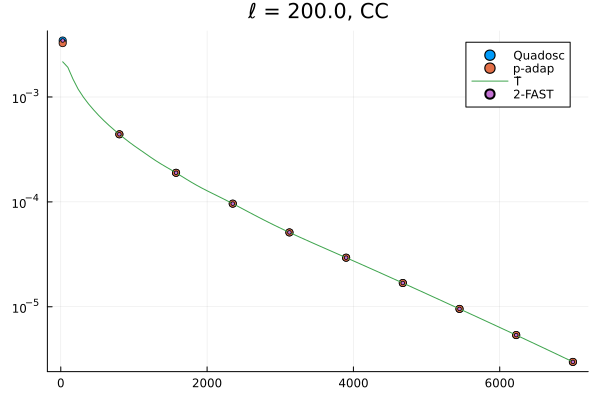

In [32]:
#scatter(χ_list, result_Ia_CC .- result_Ib_CC, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CC, label = "Quadosc", yscale=:log10, title="ℓ = $ℓ, CC")
scatter!(χ_list, result_pquad_CC, label = "p-adap")
plot!(χ, diag(w_CC[lidx,:,:]), label="T̃")
scatter!(χ_list, w_2F_CC, label="2-FAST", markersize = 2)

# Doing everything without a $\chi$ evolution

### LL

In [33]:
result_Ia_LL2 = calc_qosc(χ_list, "LL",  ℓ, 1.0, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 21.810920 seconds (14.99 M allocations: 1.263 GiB, 0.30% gc time, 0.75% compilation time)


In [34]:
result_pquad_LL2 = calc_pad(χ_list, "LL", ℓ, 1.0, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  0.866312 seconds (8.72 M allocations: 714.448 MiB, 7.61% gc time, 12.15% compilation time)


In [35]:
w00_LL_2F = calculate_2FAST(χ_list, "LL", ℓ, 1.0, power_spectrum);

  q=-2.5, R=1.0:	  0.007543 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006115 seconds (180 allocations: 638.031 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[1.6604426825925316e-32 + 0.0im, 0.0 + 0.0im]
ell 202, elapsed: 2.002716064453125e-5
ell 201, elapsed: 0.0002300739288330078
ell 200, elapsed: 0.00023102760314941406
ell 199, elapsed: 0.0011241436004638672
ell 198, elapsed: 0.001123189926147461
  0.004383 seconds (339 allocations: 18.039 KiB)
elapsed: 0.00144195556640625
step:          0.000406 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000115 sec (0 allocations: 0 byte, 0.0% gc 

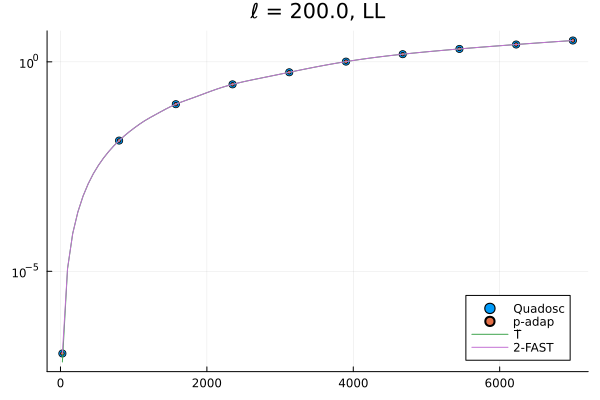

In [36]:
scatter(χ_list, result_Ia_LL2, label = "Quadosc", title="ℓ = $ℓ, LL")
scatter!(χ_list, result_pquad_LL2, label = "p-adap", markersize = 2)
plot!(χ, diag(w_LL2[lidx,:,:]), label="T̃")
plot!(χ, w00_LL_2F, label="2-FAST", yscale=:log10, legend=:bottomright)

### CL

In [37]:
#result_Ia_CL2, result_Ib_CL2  = calc_qosc(χ_list, "CL", ℓ, true, power_spectrum);
result_Ia_CL2  = calc_qosc(χ_list, "CL", ℓ, 1.0, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 60.460627 seconds (39.68 M allocations: 5.985 GiB, 0.62% gc time)


In [38]:
result_pquad_CL2 = calc_pad(χ_list, "CL", ℓ, 1.0, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  1.170080 seconds (13.79 M allocations: 1.105 GiB, 4.97% gc time)


In [39]:
w00_CL_2F = calculate_2FAST(χ_list, "CL", ℓ, 1.0, power_spectrum);

  q=0.5, R=1.0:	  0.008047 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005145 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[-0.13859567687499944 + 1.697307520606289e-17im, 0.0 + 0.0im]
ell 202, elapsed: 1.811981201171875e-5
ell 201, elapsed: 0.00023508071899414062
ell 200, elapsed: 0.00017189979553222656
ell 199, elapsed: 0.0010120868682861328
ell 198, elapsed: 0.0010249614715576172
  0.003992 seconds (339 allocations: 18.039 KiB)
elapsed: 0.0013320446014404297
step:          0.000356 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000102 sec (0 allocations

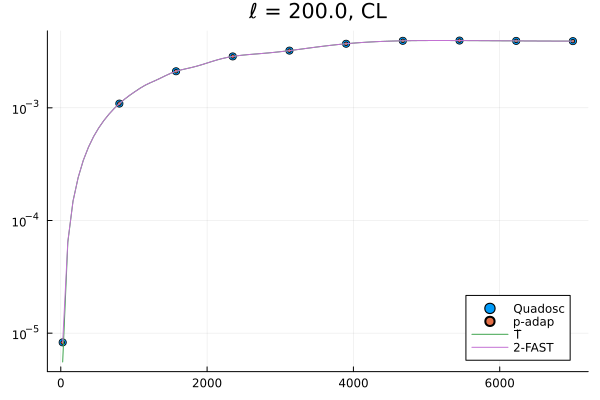

In [40]:
#scatter(χ_list, result_Ia_CL2 .- result_Ib_CL2, label = "Quadosc")
scatter(χ_list, result_Ia_CL2, label = "Quadosc", title="ℓ = $ℓ, CL", yscale=:log10)
scatter!(χ_list, result_pquad_CL2, label = "p-adap", markersize=2)
plot!(χ, diag(w_CL2[lidx,:,:]), label="T̃", legend=:bottomright)
plot!(χ, w00_CL_2F, label="2-FAST")

### CC

In [41]:
#result_Ia_CC2, result_Ib_CC2 = calc_qosc(χ_list, "CC", ℓ, true, power_spectrum)
result_Ia_CC2 = calc_qosc(χ_list, "CC", ℓ, 1.0, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
789.619925 seconds (476.88 M allocations: 469.309 GiB, 2.92% gc time)


In [42]:
result_pquad_CC2 = calc_pad(χ_list, "CC", ℓ, 1.0, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  2.794940 seconds (32.37 M allocations: 2.595 GiB, 6.90% gc time)


In [43]:
w00_CC_2F = calculate_2FAST(χ_list, "CC", ℓ, 1.0, power_spectrum);

  q=1.1, R=1.0:	  0.008547 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.004322 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[126981.089296192 - 3.110139691176515e-11im, 0.0 + 0.0im]
ell 202, elapsed: 2.002716064453125e-5
ell 201, elapsed: 0.0002620220184326172
ell 200, elapsed: 0.0002129077911376953
ell 199, elapsed: 0.0010600090026855469
ell 198, elapsed: 0.0010650157928466797
  0.004272 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0014319419860839844
step:          0.000383 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      2.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000121 sec (0 allocations: 0 by

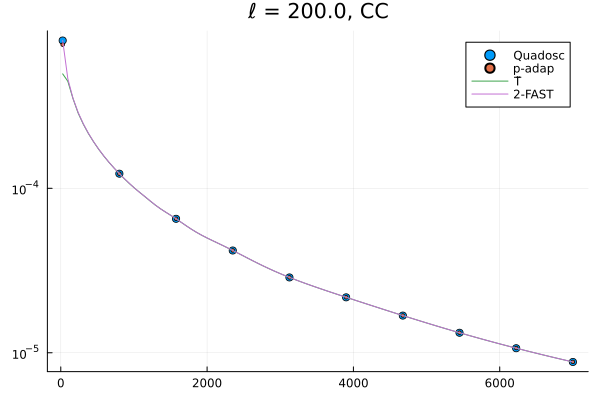

In [44]:
#scatter(χ_list, result_Ia_CC2 .- result_Ib_CC2, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CC2, label = "Quadosc", yscale=:log10, title="ℓ = $ℓ, CC")
scatter!(χ_list, result_pquad_CC2, label = "p-adap", markersize = 2)
plot!(χ, diag(w_CC2[lidx,:,:]), label="T̃")
plot!(χ, w00_CC_2F, label="2-FAST")

# VALIDATING THE OFF-DIAGONAL TERMS (no $\chi$ dependence in P(k))

In [22]:
T_CC_0999 = load_Ts("T_validation/RR_0999_CC")
T_CL_0999 = load_Ts("T_validation/RR_0999_CL")
T_LL_0999 = load_Ts("T_validation/RR_0999_LL")

w_CC_0999 = Will.w_ell_tullio(coeff2, T_CC_0999)
w_CL_0999 = Will.w_ell_tullio(coeff2, T_CL_0999)
w_LL_0999 = Will.w_ell_tullio(coeff2, T_LL_0999);

In [23]:
T_CC_095 = load_Ts("T_validation/RR_095_CC")
T_CL_095 = load_Ts("T_validation/RR_095_CL")
T_LL_095 = load_Ts("T_validation/RR_095_LL")

w_CC_095 = Will.w_ell_tullio(coeff2, T_CC_095)
w_CL_095 = Will.w_ell_tullio(coeff2, T_CL_095)
w_LL_095 = Will.w_ell_tullio(coeff2, T_LL_095);

In [24]:
T_CC_09 = load_Ts("T_validation/RR_09_CC")
T_CL_09 = load_Ts("T_validation/RR_09_CL")
T_LL_09 = load_Ts("T_validation/RR_09_LL")

w_CC_09 = Will.w_ell_tullio(coeff2, T_CC_09)
w_CL_09 = Will.w_ell_tullio(coeff2, T_CL_09)
w_LL_09 = Will.w_ell_tullio(coeff2, T_LL_09);

In [25]:
T_CC_075 = load_Ts("T_validation/RR_075_CC")
T_CL_075 = load_Ts("T_validation/RR_075_CL")
T_LL_075 = load_Ts("T_validation/RR_075_LL")

w_CC_075 = Will.w_ell_tullio(coeff2, T_CC_075)
w_CL_075 = Will.w_ell_tullio(coeff2, T_CL_075)
w_LL_075 = Will.w_ell_tullio(coeff2, T_LL_075);

In [26]:
T_CC_05 = load_Ts("T_validation/RR_05_CC")
T_CL_05 = load_Ts("T_validation/RR_05_CL")
T_LL_05 = load_Ts("T_validation/RR_05_LL")

w_CC_05 = Will.w_ell_tullio(coeff2, T_CC_05)
w_CL_05 = Will.w_ell_tullio(coeff2, T_CL_05)
w_LL_05 = Will.w_ell_tullio(coeff2, T_LL_05);

In [27]:
T_CC_01 = load_Ts("T_validation/RR_01_CC")
T_CL_01 = load_Ts("T_validation/RR_01_CL")
T_LL_01 = load_Ts("T_validation/RR_01_LL")

w_CC_01 = Will.w_ell_tullio(coeff2, T_CC_01)
w_CL_01 = Will.w_ell_tullio(coeff2, T_CL_01)
w_LL_01 = Will.w_ell_tullio(coeff2, T_LL_01);

### LL

In [28]:
#W_2F_LL_0999 = calculate_2FAST(χ, "LL", ℓ, 0.999, power_spectrum);
W_2F_LL_095 = calculate_2FAST(χ, "LL", ℓ, 0.95, power_spectrum);
W_2F_LL_09 = calculate_2FAST(χ, "LL", ℓ, 0.9, power_spectrum);
W_2F_LL_075 = calculate_2FAST(χ, "LL", ℓ, 0.75, power_spectrum);
W_2F_LL_05 = calculate_2FAST(χ, "LL", ℓ, 0.5, power_spectrum);
W_2F_LL_01 = calculate_2FAST(χ, "LL", ℓ, 0.1, power_spectrum);

  q=-2.5, R=0.95:	  0.782988 seconds (1.63 M allocations: 249.882 MiB, 9.79% gc time, 2.85% compilation time)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006668 seconds (182 allocations: 638.156 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[8.635251447913896e-29 + 0.0im, 8.956429106840469e-29 + 0.0im]
ell 22, elapsed: 2.9087066650390625e-5
ell 21, elapsed: 0.26799702644348145
ell 20, elapsed: 0.0033359527587890625
ell 19, elapsed: 0.0010271072387695312
ell 18, elapsed: 0.00102996826171875
  0.293152 seconds (454.89 k allocations: 30.508 MiB, 1.73% gc time, 98.38% compilation time)
elapsed: 0.0014600753784179688
step:          0.086805 sec (107.51 k allocations: 7.591 MB, 5.84% gc time)
swapping:      4.0e-

In [29]:
#w_qosc_LL_0999 =  calc_qosc(χ_list, "LL", ℓ, 0.999, true, power_spectrum);
#w_qosc_LL_095 =  calc_qosc(χ_list, "LL", ℓ, 0.95, true, power_spectrum);
#w_qosc_LL_09 =  calc_qosc(χ_list, "LL", ℓ, 0.9, true, power_spectrum);
#w_qosc_LL_075 =  calc_qosc(χ_list, "LL", ℓ, 0.75, true, power_spectrum);
w_qosc_LL_05 =  calc_qosc(χ_list, "LL", ℓ, 0.5, true, power_spectrum);
#w_qosc_LL_01 =  calc_qosc(χ_list, "LL", ℓ, 0.1, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
  1.311642 seconds (1.81 M allocations: 103.967 MiB, 1.00% gc time, 39.37% compilation time)


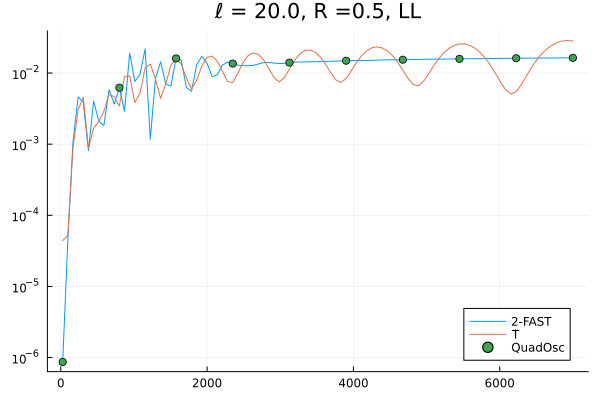

In [30]:
plot(χ, abs.(W_2F_LL_05), label="2-FAST", title = "ℓ = $ℓ, R =0.5, LL")
#scatter!(χ_list, result_pquad, label="p-ad")
plot!(χ, abs.(diag(w_LL_05[lidx,:,:])), label="T̃", yscale=:log10)
scatter!(χ_list, abs.(w_qosc_LL_05), label="QuadOsc", legend=:bottomright)

In [46]:
@time T_test = T̃_qosc_style(power_spectrum, ℓ, χ, 0.5, kmin, kmax, "LL");

Processing χ = 26.0...
Processing χ = 96.44444444444446...
Processing χ = 166.8888888888889...
Processing χ = 237.33333333333334...
Processing χ = 307.7777777777778...
Processing χ = 378.22222222222223...
Processing χ = 448.6666666666667...
Processing χ = 519.1111111111111...
Processing χ = 589.5555555555557...
Processing χ = 660.0...
Processing χ = 730.4444444444445...
Processing χ = 800.8888888888888...
Processing χ = 871.3333333333334...
Processing χ = 941.7777777777778...
Processing χ = 1012.2222222222222...
Processing χ = 1082.6666666666667...
Processing χ = 1153.1111111111113...
Processing χ = 1223.5555555555557...
Processing χ = 1294.0...
Processing χ = 1364.4444444444443...
Processing χ = 1434.888888888889...
Processing χ = 1505.3333333333335...
Processing χ = 1575.7777777777776...
Processing χ = 1646.2222222222224...
Processing χ = 1716.6666666666667...
Processing χ = 1787.1111111111113...
Processing χ = 1857.5555555555557...
Processing χ = 1928.0...
Processing χ = 1998.444444

In [56]:
w_test = Will.w_ell_tullio(coeff3, T_test);

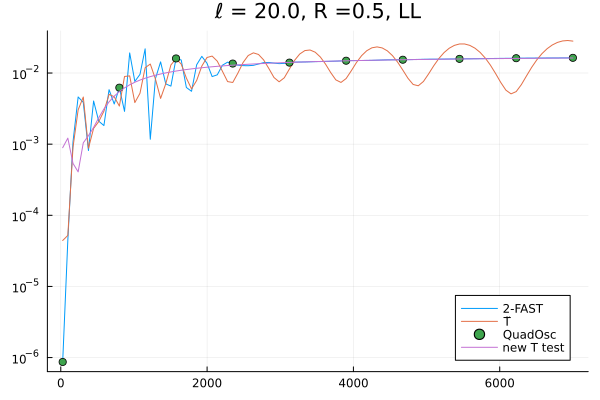

In [57]:
plot(χ, abs.(W_2F_LL_05), label="2-FAST", title = "ℓ = $ℓ, R =0.5, LL")
#scatter!(χ_list, result_pquad, label="p-ad")
plot!(χ, abs.(diag(w_LL_05[lidx,:,:])), label="T̃", yscale=:log10)
scatter!(χ_list, abs.(w_qosc_LL_05), label="QuadOsc", legend=:bottomright)
plot!(χ, abs.(diag(w_test[1,:,:])), label = "new T test" )

### CL

In [30]:
#W_2F_CL_0999 = calculate_2FAST(χ, "CL", ℓ, 0.999, power_spectrum);
#W_2F_CL_095 = calculate_2FAST(χ, "CL", ℓ, 0.95, power_spectrum);
#W_2F_CL_09 = calculate_2FAST(χ, "CL", ℓ, 0.9, power_spectrum);
#W_2F_CL_075 = calculate_2FAST(χ, "CL", ℓ, 0.75, power_spectrum);
W_2F_CL_05 = calculate_2FAST(χ, "CL", ℓ, 0.5, power_spectrum);
#W_2F_CL_01 = calculate_2FAST(χ, "CL", ℓ, 0.1, power_spectrum);

  q=0.5, R=0.999:	 23.359204 seconds (51.83 M allocations: 4.872 GiB, 0.23% gc time, 0.01% compilation time)

ℓ = 50
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005348 seconds (180 allocations: 638.023 KiB)
ellmax: 52
lmaxcache: 50
fell[:,1,1] = ComplexF64[-0.8019895750503191 + 9.821539660349192e-17im, -2.104786349783526 + 2.5776198661514366e-16im]
ell 52, elapsed: 1.9073486328125e-5
ell 51, elapsed: 0.0001850128173828125
ell 50, elapsed: 0.0002307891845703125
ell 49, elapsed: 0.001065969467163086
ell 48, elapsed: 0.0010790824890136719
  0.004225 seconds (339 allocations: 19.727 KiB)
elapsed: 0.0014569759368896484
step:          0.000379 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      2.0e-6 sec (0 allocations: 0 b

In [40]:
#w_qosc_CL_0999 =  calc_qosc(χ_list, "CL", ℓ, 0.999, true, power_spectrum);
#w_qosc_CL_095 =  calc_qosc(χ_list, "CL", ℓ, 0.95, true, power_spectrum);
#w_qosc_CL_09 =  calc_qosc(χ_list, "CL", ℓ, 0.9, true, power_spectrum);
#w_qosc_CL_075 =  calc_qosc(χ_list, "CL", ℓ, 0.75, true, power_spectrum);
w_qosc_CL_05 =  calc_qosc(χ_list, "CL", ℓ, 0.5, true, power_spectrum);
#w_qosc_CL_01 =  calc_qosc(χ_list, "CL", ℓ, 0.1, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 65.641551 seconds (23.80 M allocations: 3.201 GiB, 0.46% gc time)


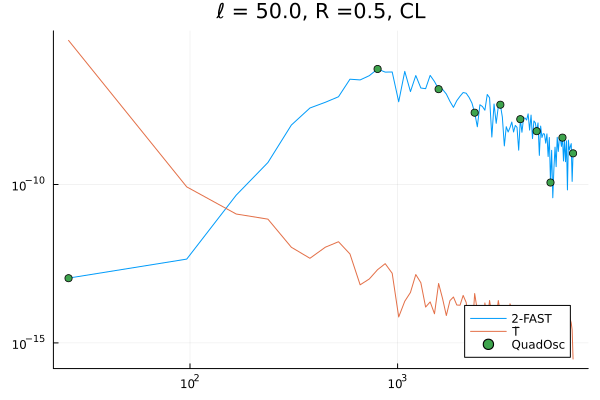

In [41]:
plot(χ, abs.(W_2F_CL_05), label="2-FAST", title = "ℓ = $ℓ, R =0.5, CL")
#scatter!(χ_list, result_pquad, label="p-ad")
plot!(χ, abs.(diag(w_CL_05[lidx,:,:])), label="T̃", yscale=:log10, xscale=:log10)
scatter!(χ_list, abs.(w_qosc_CL_05), label="QuadOsc", legend=:bottomright)

### CC

In [26]:
#W_2F_CC_0999 = calculate_2FAST(χ, "CC", ℓ, 0.999, power_spectrum);
#W_2F_CC_095 = calculate_2FAST(χ, "CC", ℓ, 0.95, power_spectrum);
#W_2F_CC_09 = calculate_2FAST(χ, "CC", ℓ, 0.9, power_spectrum);
#W_2F_CC_075 = calculate_2FAST(χ, "CC", ℓ, 0.75, power_spectrum);
W_2F_CC_05 = calculate_2FAST(χ, "CC", ℓ, 0.5, power_spectrum);
#W_2F_CC_01 = calculate_2FAST(χ, "CC", ℓ, 0.1, power_spectrum);

  q=1.1, R=0.999:	 25.346316 seconds (59.92 M allocations: 5.186 GiB, 0.46% gc time, 0.03% compilation time)

ℓ = 50
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005523 seconds (182 allocations: 638.148 KiB)
ellmax: 52
lmaxcache: 50
fell[:,1,1] = ComplexF64[255660.38715325654 - 6.261873495920175e-11im, 959640.6628925542 - 2.3504417322860216e-10im]
ell 52, elapsed: 2.7179718017578125e-5
ell 51, elapsed: 0.26558995246887207
ell 50, elapsed: 0.003674030303955078
ell 49, elapsed: 0.0010330677032470703
ell 48, elapsed: 0.0010290145874023438
  0.291675 seconds (454.89 k allocations: 30.509 MiB, 98.41% compilation time)
elapsed: 0.0013489723205566406
step:          0.083488 sec (107.51 k allocations: 7.591 MB, 0.0% gc time)
swappin

In [27]:
#w_qosc_CC_0999 =  calc_qosc(χ_list, "CC", ℓ, 0.999, true, power_spectrum);
#w_qosc_CC_095 =  calc_qosc(χ_list, "CC", ℓ, 0.95, true, power_spectrum);
#w_qosc_CC_09 =  calc_qosc(χ_list, "CC", ℓ, 0.9, true, power_spectrum);
#w_qosc_CC_075 =  calc_qosc(χ_list, "CC", ℓ, 0.75, true, power_spectrum);
w_qosc_CC_05 =  calc_qosc(χ_list, "CC", ℓ, 0.5, true, power_spectrum);
#w_qosc_CC_01 =  calc_qosc(χ_list, "CC", ℓ, 0.1, true, power_spectrum);

Processing QuadOsc for χ = 26.0


LoadError: InterruptException:

In [28]:
plot(χ, abs.(W_2F_CC_05), label="2-FAST", title = "ℓ = $ℓ, R =0.5, CC")
#scatter!(χ_list, result_pquad, label="p-ad")
plot!(χ, abs.(diag(w_CC_05[lidx,:,:])), label="T̃", yscale=:log10, xscale=:log10)
scatter!(χ_list, abs.(w_qosc_CC_05), label="QuadOsc", legend=:topright)

LoadError: UndefVarError: `w_qosc_CC_05` not defined